# Data Mining 

## PCA und Dimensionsreduzierung

> ### In God we trust, all others bring data.

>William Edwards Deming (1900-1993)


## Format der "Folien"

Hierbei handelt es sich um ein sogenanntes Jupyter Notebook.

http://jupyter.org/

Eine Mischung aus Code, Bildern und Text mit Teilweise interaktiven Elementen.
Auch lokal auf euren Laptops ausführbar. 

<img src="./ml/images/jupyter.png" alt="Jupyter Logo" style="width: 200px;"/>

## scikit-learn (sklearn)

Programmbesipiele und plots in der Vorlesung sind mithilfer des scikit-learn Projektes erstellt.

[http://scikit-learn.org/stable](http://scikit-learn.org/stable)

scikit-learn ist eine Bibliothek für Python mit vielen fertigen Methoden und Algortihmen für Data Mining / Machine Learning

Ausführlicher User-Guide mit Beispielen und mathematischen Hintegründen

[http://scikit-learn.org/stable/user_guide.html](http://scikit-learn.org/stable/user_guide.html)

<img src="./ml/images/logo.png" alt="Scikit Logo" style="width: 200px;"/>

Installation (wie immer)

    pip install sklearn
    
oder 
    
    conda install sklearn


![sklearn citations](./ml/images/sklearn_citations.png)

### Notationen

*Für weiteres siehe "Elements of statistical Learning" von Trevor Hastie. https://web.stanford.edu/~hastie/ElemStatLearn/ (Kostenloses E-Book)* 

Ich versuche folgenden Namenskonventionen zu folgen.

* Großbuchstaben wie  $X$ oder $Y$ bezeichnen generische Aspekte einer Variable (i.e. die tatsächliche Zufallsvariable)
* Beobachtungen/Realisierungen werden klein geschrieben. Die i-te Realisierung in $X$ ist $x_i$
* Matrizen sind groß- und fettgedruckt $\mathbf{X}$
* Beobachtungen/Realisierungen sind *Zeilen* der Matrix während die beobachteten Größen in den *spalten* stehen.

Wenn man beispielsweise $d=2$ Variablen, das Alter und das Gewicht von $N = 100$ Menschen misst, dann erhält man eine $N \times d$ Matrix $\mathbf{X}$.

eine Beobachtung, bzw. Zeile, der Matrix wird geschrieben als $x_i = [ Alter, Gewicht ]$. Alle Messungen der Größe *Gewicht* sind geschrieben als  $\mathbf{x}_1$ 

In [1]:
%matplotlib inline
from ml import plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

discrete_cmap = LinearSegmentedColormap.from_list('discrete', colors = [(0.8, 0.2, 0.3), (0.1, 0.8, 0.3), (0, 0.4, 0.8)], N=3)

def set_rc_params():
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 14
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['xtick.labelsize'] = 13
    plt.rcParams['ytick.labelsize'] = 13
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['legend.fontsize'] = 13
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False

def set_sns():
    sns.set(context='notebook')
    set_rc_params()

    
def set_mpl():
    sns.reset_orig()
    set_rc_params()


def draw_linear_regression_function(reg, ax=None, **kwargs):
    if not ax:
        ax = plt.gca()
        
    if reg.coef_.ndim > 1:
        b_1, b_2 = reg.coef_[0, :]
    else:
        b_1, b_2 = reg.coef_
    
    
    b_0 = reg.intercept_

    # solve the function y = b_0 + b_1*X_1 + b_2 * X_2 for X2

    x_low, x_high = ax.get_xlim()
    x1s = np.linspace(x_low, x_high)
    x2s = (0.5 - b_0 - b_1 * x1s) / b_2

    ax.plot(x1s, x2s, **kwargs)

def plot_3d_views(X, y):
    from mpl_toolkits.mplot3d import Axes3D
    set_mpl()

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(2, 2, 1, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=discrete_cmap)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')

    ax = fig.add_subplot(2, 2, 2, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=discrete_cmap)
    ax.view_init(0, 0)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')

    ax = fig.add_subplot(2, 2, 3, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=discrete_cmap)
    ax.view_init(0, 90)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')

    ax = fig.add_subplot(2, 2, 4, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=discrete_cmap)
    ax.view_init(90, 0)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    

set_mpl()

Beim letzten mal:

Lineare Fisher Diskriminanzanalyse:

> Finde die Hyperebenen welche zwei Populationen optimal nach Fisher Kriterium trennt.

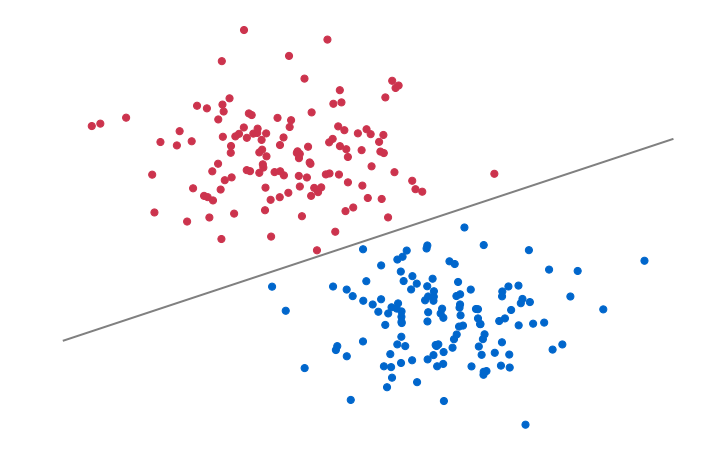

In [2]:
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X, y = make_blobs(n_samples=250, centers=2, random_state=12)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=discrete_cmap)

clf = LinearDiscriminantAnalysis()
lda = clf.fit(X, y)
draw_linear_regression_function(lda, color='gray')
plt.axis('off')
None

### Probleme bei hochdimnesionalen Daten:

> #### Curse of dimensionality (Fluch der Dimensionalität)
>ist ein Begriff, der von Richard Bellman eingeführt wurde, um den rapiden Anstieg im Volumen beim Hinzufügen weiterer Dimensionen in einen mathematischen Raum zu beschreiben.

>[https://de.wikipedia.org/wiki/Fluch_der_Dimensionalität](https://de.wikipedia.org/wiki/Fluch_der_Dimensionalit%C3%A4t)

Je höher die Dimension des Raumes, umso mehr Beobachtungen braucht man um den Raum *ausreichend* abzudecken.

Im folgenden Beispiel werden 100 Punkte aus eine uniformen Verteilung zwischen 0 und 1 gezogen.
Darunter wird das Histogram gezeichnet.  Zunächst in einer Dimension und dann in zwei.

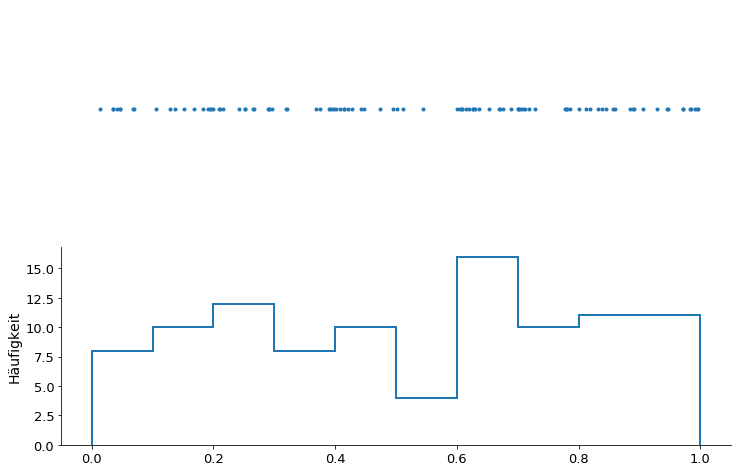

In [3]:
sample = np.random.uniform(low=0.0, high=1.0, size=100)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(sample, np.zeros_like(sample), '.')
ax1.axis('off')

ax2.hist(sample, bins=np.arange(0, 1.1, 0.1),histtype='step', lw=2)
ax2.set_ylabel('Häufigkeit')
None

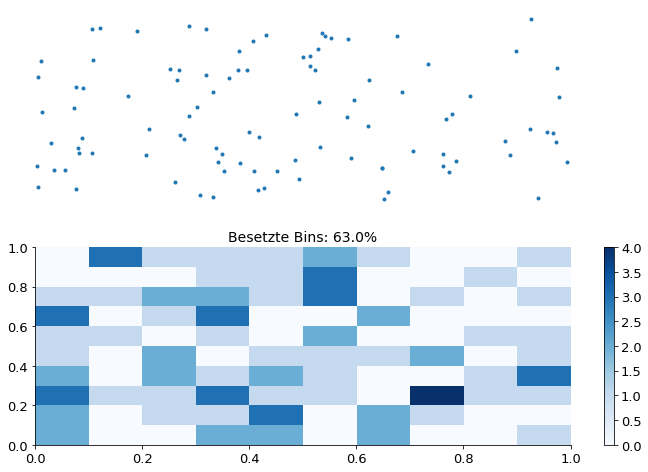

In [4]:
sample = np.random.uniform(low=0.0, high=1.0, size=[100, 2])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(sample[:, 0], sample[:, 1], '.')
ax1.axis('off')
h, _, _, im = ax2.hist2d(sample[:, 0], sample[:, 1], bins=np.arange(0, 1.1, 0.1), cmap='Blues', vmin=0)

density = np.count_nonzero(h)/h.ravel().shape[0] * 100
ax2.set_title('Besetzte Bins: {}%'.format(density))
fig.colorbar(im, ax=ax2)
fig.colorbar(im, ax=ax1).ax.set_visible(False)
None

Im 1D Beispiel ist jeder Bin besetzt. Es gibt keine leeren bins. Im 2D Beispiel sind bereits ungefähr ein Drittel der Bins leer. 

Lösungsmöglichkeiten:

1. Mehr Daten Speichern und höhere Kosten in Kauf nehmen.
2. Größere Bins benutzen und die Verteilung weniger genau wiedergeben.
3. Dimensionen reduzieren und eventuell Informationen verwerfen. 

Hochdimensionale Daten führen aber auch zu ganz Grundsätzlichen, mathematischen,  Problemen.
Interessante Diskussion hier: 
> Why is Euclidean distance not a good metric in high dimensions?
>https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions


In [5]:
%%html
<style>
.column {
    float: left;
    width: 50%;
}

/* Clear floats after the columns */
.row:after {
    content: "";
    display: table;
    clear: both;
}
</style>

<h3> Beispiel IceCube Detektor </h3>
</br>
 <div class="row">
  <div class="column">
  <img src="./ml/images/icecube.jpg" alt="Drawing" style="width: 400px;"/>
  </div>
  <div class="column">
    
    <p>Der IceCube Neutrino Detektor am Südpol nimmt bis zu 1 TB Daten am Tag auf. </p>
    <p>Per Satelit können nur 100 GB pro Tag übetragen werden. </p>
    <p>Die restlichen Daten werden einmal pro Jahr per Schiff versandt.</p>
    </br>
    &rarr; Viele Daten kosten viel Geld.
</div> 


## Datenreduktion

Zwei grundsätzliche Ansätze:

 1. Feature Extraction
   
       -   Erzeugen neuer Attribute, die Informationen mehrerer Attribute zusammenfassen
       -   Transformation des Datenraumes (Hauptkomponenteanalyse)
   
 2. Feature Selection
   
       - Verwerfen von redundanten und schwachen Attributen

### Feature Extraction

##### Einfaches Beispiel für Datentransformation

Gegeben seien Datenpunkte $X = (x_1, x_2, ...) , Y = (y_1, y_2, ...) $.

Angenommen durch Fachwissen, bekannte physikalische Zusammenhänge oder einfach genaues hinsehen sei bekannt, 
dass die Daten sich besser durch Polarkoordinaten ausdrücken lassen.

$$
 \begin{align}
     r =& x^2 + y^2 \\
     \phi =& arctan2(y, x)    
 \end{align}
$$

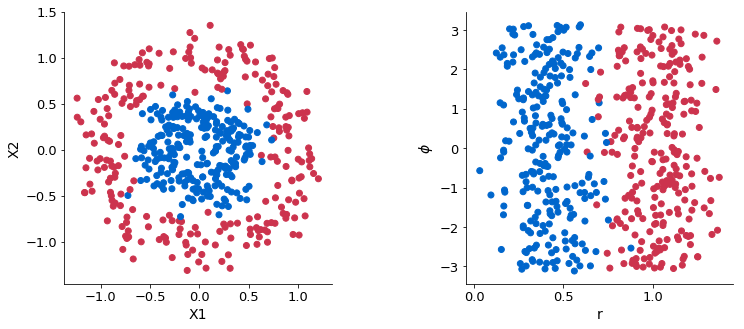

In [6]:
from sklearn.datasets import make_circles

def transform(X1, X2):
    r = np.sqrt(X1**2 + X2**2)
    phi = np.arctan2(X2, X1)
    return r, phi

X, y = make_circles(n_samples=500, noise=0.15, factor=0.4, )
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.5)
ax1.scatter(X[:, 0], X[:, 1], c=y, cmap=discrete_cmap)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')

r, phi = transform(X[:, 0], X[:, 1])
ax2.scatter(r, phi, c=y, cmap=discrete_cmap)
ax2.set_xlabel('r')
ax2.set_ylabel('$\phi$')

In diesem Beispiel reicht es völlig allein das Attribut $r$ zu speichern um die Daten in zwei klassen zu unterteilen.

Diese Art der Feature Extraction erfordert irgend eine Art von Expertenwissen und wird bei steigender Dimensionalität komplizierter.

#### PCA (Hauptkomponentenanalyse)

Die Hauptkomponentenanalyse sucht nach einer Basis im Raum indem die Varianz entlang der Basisvektoren maximiert wird.

Gegeben seien also $N$ Datenpunkte mit $d$ Dimensionen die auf $k < d$ Dimensionen transformiert werden sollen.

Dazu wird der Raum in eine neue Basis transformiert. Es werden also eventuell mehrere Dimensionen/Attribute zu einer neuen Zusammengefasst.  

Grober Ablauf der PCA

0. Zentriere die Daten auf ihren Mittelwert.
1. Berechne die Kovarianzmatrix aus der Datenmatrix $\mathbf{X}$
2. Berechne Eigenwerte und Eigenvektoren der Matrix
3. Wähle die $k$ größten Eigenwerte und zugehörigen Eigenvektoren aus. 
4. Bilde eine $d \times k$ Matrix $\mathbf{W}$ mit den $k$ Eigenvektoren als Spalten.
5. Wende $\mathbf{W}$ auf jede Zeile aus $x$ aus $\mathbf{X}$ an $x^\prime = \mathbf{W}^T \cdot x^T $ 
    

###### 1. Zentrierung 

Berechne die Mittelwertvektoren $\mu$:

$$
\mathbf{\mu} = \begin{pmatrix}
    \bar{\mathbf{x}}_1 \\
    \ldots \\
    \bar{\mathbf{x}}_d \\
\end{pmatrix}
 = \frac 1 N
 \begin{pmatrix}
    \sum_{i=0}^{N} \mathbf{x}_{1, i} \\
    \ldots \\
    \sum_{i=0}^{N} \mathbf{x}_{d, i} \\
\end{pmatrix}
$$

Anders ausgedrückt:
$$
\mathbf{\mu} = \begin{pmatrix}
    \text{Mittelwert aller Beobachtungen von Attribut 1}\\
    \ldots \\
    \text{Mittelwert aller Beobachtungen von Attribut d}\\
\end{pmatrix}
$$

Neuer Datenpunkt:

   $$
      x^{\prime}_i = x_i - \mathbf{\mu}
   $$

###### 2. Kovarianz

Die Kovarianz zweier Zufallsvariablen.
$$
\operatorname {Cov} (X,Y)=\operatorname {E} {\bigl [}(X-\operatorname {E} (X))\cdot (Y-\operatorname {E} (Y)){\bigr ]}
$$

Für mehr als zwei Variablen in Matrixschreibweise

$$
\operatorname {Cov} (\mathbf {X} ) = \operatorname {E} {\bigl (}(\mathbf {X} -\mathbf {\mu } )(\mathbf {X} -\mathbf {\mu } )^{T}{\bigr )}
$$


###### 3. Eigenwerte und Vektoren

Berechne die $d$ verschiedenen Eigenwerte der Kovarianzmatrix $ \operatorname {Cov} (\mathbf {X} )$.

Erhalte Eigenwerte $\lambda_1, \ldots, \lambda_d$ mit passenden Eigenvektoren $v_1, \ldots, v_d$


###### 4. Sortierung und Auswahl

Sortiere die Indizes der Eigenwerte und Vektoren so dass gilt 

$$
\lambda_1 > \lambda_2 > \lambda_3 \ldots > \lambda_d
$$

Wähle die $k$ größten Eigenwerte aus und verwerfe alle anderen Eigenwerte und Vektoren.



###### 5. Bildung der Matrix

Nutze die $k$ ausgewählten Eigenvektoren als Spalten in der Matrix $\mathbf{W}$

$$
\mathbf{W} = \begin{pmatrix}
    v_1, 
    \ldots,  
    v_k
\end{pmatrix}
= \begin{pmatrix}
    v_{1,1}, 
    \ldots,  
    v_{k, 1} \\
    \ldots \\
        v_{1,d}, 
    \ldots,  
    v_{k, d}
\end{pmatrix}
$$

###### 6. Transformierung 

Multipliziere die Transformationsmatrix $\mathbf{W}$ mit jeder Beobachtung $x_i$ in $\mathbf{X}$ um die auf $k$ Dimensionen beschränkten Punkte zu erhalten.

$$
x_i^\prime = \mathbf{W}^T \cdot x_i^T  
$$

#### Beispiel in 3D

Künstlicher Datensatz mit $d = 3$ Dimensionen wird auf $k=2$ Dimensionen reduziert. 
Der Datensatz wird gezogen aus zwei Gaussverteilungen mit unterschiedlichen Mittelwerten und gleicher Kovarianzmatrix.
Die Darstellung unten Zeigt die Punktwolke aus vier Verschiedenen Richtungen.

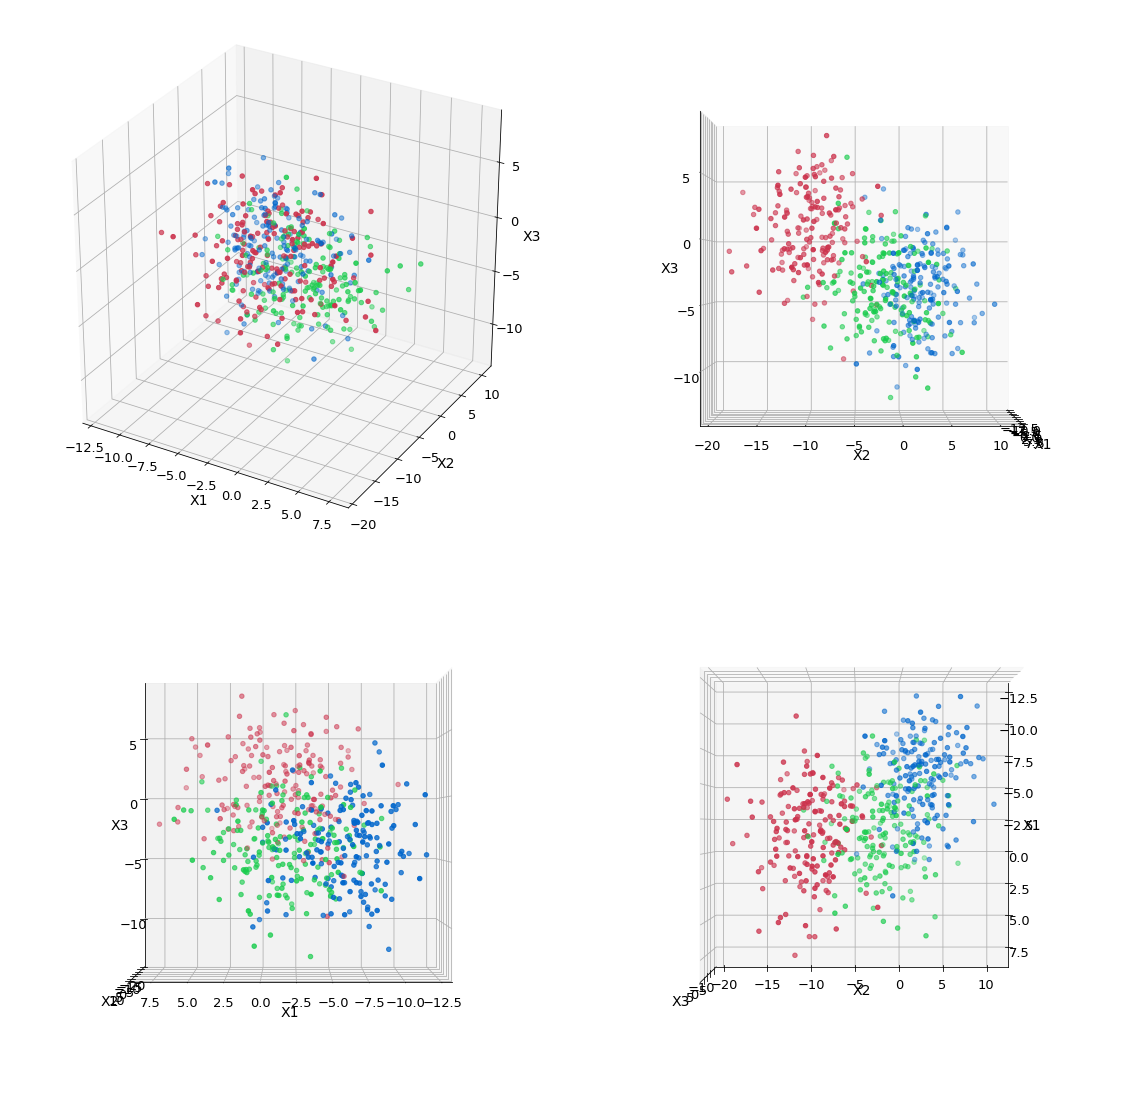

In [7]:
X, y = make_blobs(n_samples=500, n_features=3, random_state=2, cluster_std=3)
plot_3d_views(X, y)

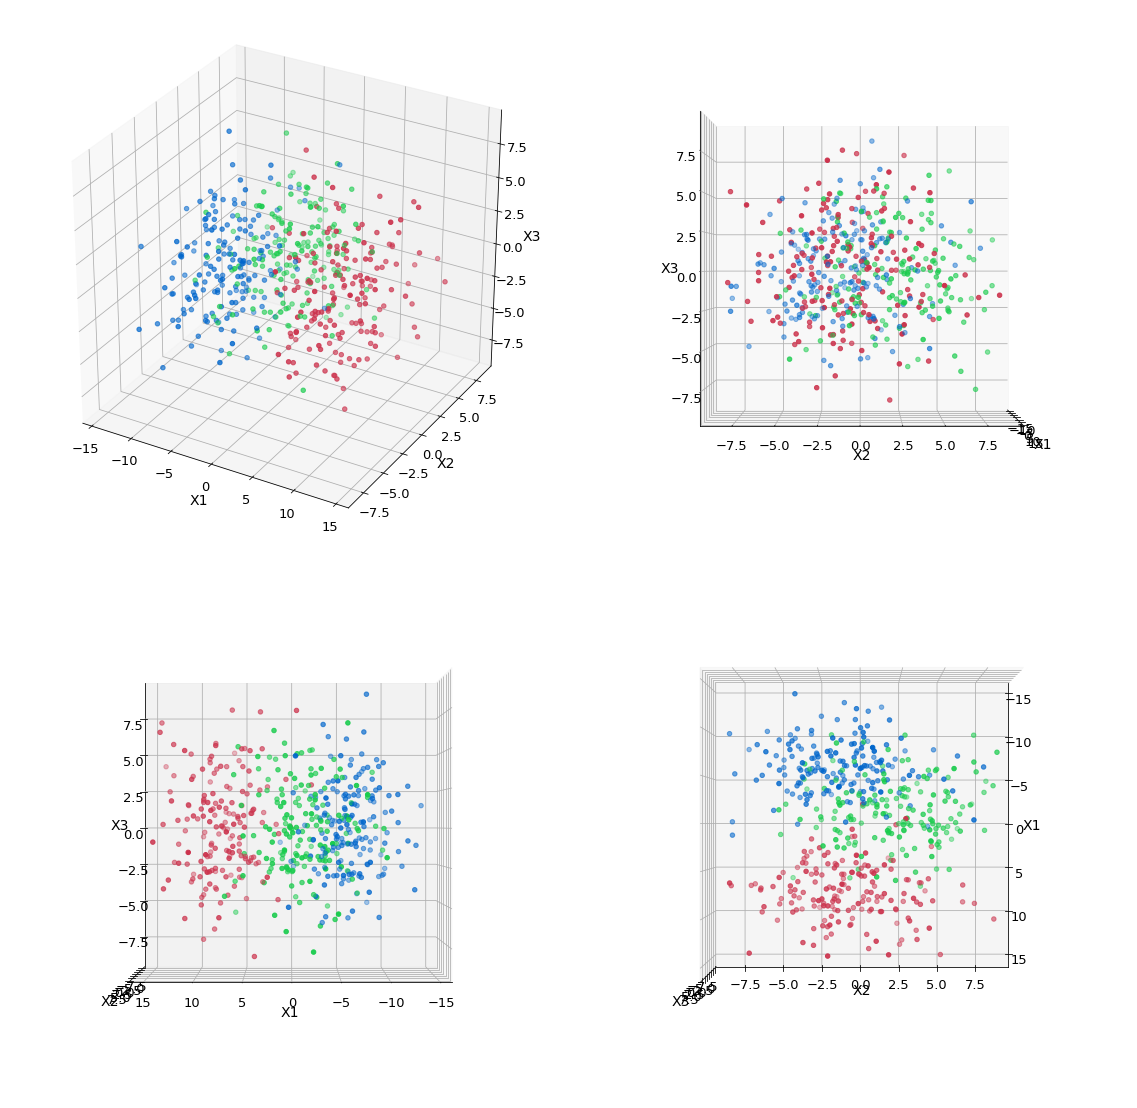

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
transformed = pca.fit_transform(X)

plot_3d_views(transformed, y)

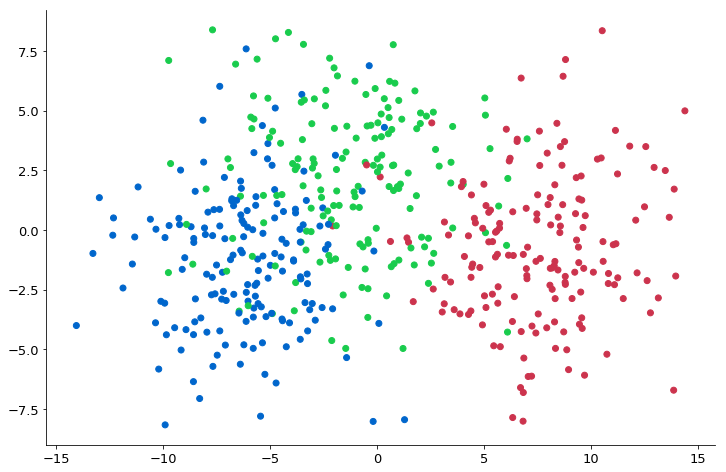

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
transformed = pca.fit_transform(X)
plt.scatter(transformed[:, 0], transformed[:, 1], c=y, cmap=discrete_cmap)
None

#### Beispiel Gesichtserkennung 

Man betrachte jeden einzelnen Pixel eines Bildes als Attribut dessen Wert der Grauwert der wert des Attributes ist.

So wird ein Bild zu einem 1D Vektor. Mehrere Bilder ergeben wieder die Datenmatrix $\mathbf{X}$

Ein Bild mit $64 \times 64$ Pixeln wird so zu einem Vektor der Länge $4096$.

##### Ein einfacher Gesichtserkennungsalgorithmus

Angenommen die Aufgabe wäre die Zuordnung von Fotos aller Studenten der TU zu deren Namen. 
Gesucht wird also eine Funktion die aus einem Foto einen Namen macht. 

Idee:
1. Speichere Bilder von allen Studenten in einer Matrix $\mathbf{X}$ der Dimension $\text{Anzahl Studenten} \times \text{Anzahl Pixel}$ und einen Labelvektor $y$ der Länge $N$ der die Namen (oder Matrikelnummern) enthält.
2. Berechne die Distanz $D$ zwischen einem neuen Foto $x_{\text{neu}}$ zu allen in $\mathbf{X}$ gespeicherten Bildern. 
3. Gebe zurück das $y_i$ für das $i$ bei dem $D(x_{\text{neu}}, x_i)$ minimal ist.

Probleme: 
 - Alle Bilder zu speichern ist schwierig bis unmöglich. 
 - Die Distanz zu allen Einträgen zu finden kann zu lange dauern.
 - Wahl des Distanzmaßes in hohen Dimensionen ist nicht trivial.
 
##### Eigenfaces 

*Original Artikel von 1991 von Turk und Pentland http://www.mitpressjournals.org/doi/10.1162/jocn.1991.3.1.71*

Der Input in den Algorithmus ist der selbe wie oben. Die Matrix aller Fotos $\mathbf{X}$. Diesmal wird diese Matrix jedoch nicht komplett abgespeichert.

Idee:
1. Wende PCA auf $X$ an. 
2. Erhalte Transformationsmatrix $\mathbf{W}$ der Dimension $d \times k$
3. Berechne Gewichte $g_m = \mathbf{v}_m^T \cdot(x_i - \mathbf{\mu}) $ für jedes gespeicherte Bild $x_i$ und jeden Eigenvektor $\mathbf{v}_m$ mit $m \in \{1, \ldots, k\}$ und erhalte so einen Gewichtsvektor $G$ der länge $k$.
4. Berechne Distanz $D$ zwischen dem Gewichtsvektor eines neuen Bildes $G_{\text{neu}}$ zur allen Gewichtsvektoren in der alten Bilder aus. 
5. Gebe zurück das $y_i$ für das $i$ bei dem $D(G_{\text{neu}}, G^{i})$ minimal ist.

In der Realität ist die Berechnung der PCA auf großen Matrizen nicht immer Trivial.

###### Python Beispiel für Eigenfaces

Der LFW (Labeled Faces in the Wild) Datensatz ist ein beliebter Datesatz für Algorithmen zur Gesichtserkennung.
http://vis-www.cs.umass.edu/lfw/
Er enthält etwa 13.000 Bilder von mehreren hundert Personen die aus dem Internet heruntergeladen wurden.

Für dieses Beispiel gucken wir uns nur 200 der Bilder an um Rechenzeit zu sparen. 

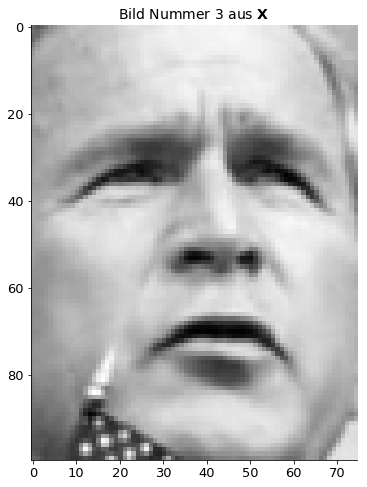

In [10]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.8)

n_faces = 200

X = lfw_people.data[0:n_faces]
y = lfw_people.target[0:n_faces]

_, h, w = lfw_people.images.shape
img = X[2].reshape(h, w)
plt.imshow(img, cmap='gray')
plt.title('Bild Nummer 3 aus $\mathbf{X}$')
None

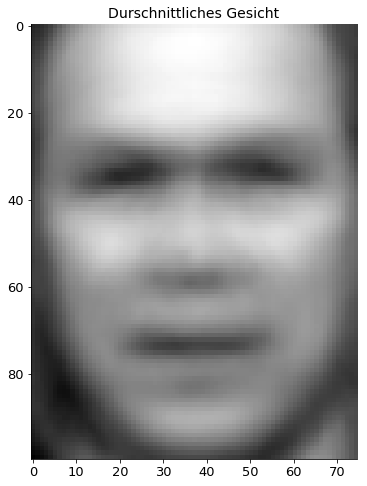

In [11]:
mean_face = X.mean(axis=0).reshape(h, w)
plt.imshow(mean_face, cmap='gray')
plt.title('Durschnittliches Gesicht')

In [12]:
n_components = 100
pca = PCA(n_components=n_components)
pca.fit(X)

eigenfaces = pca.components_.reshape((n_components, h, w))

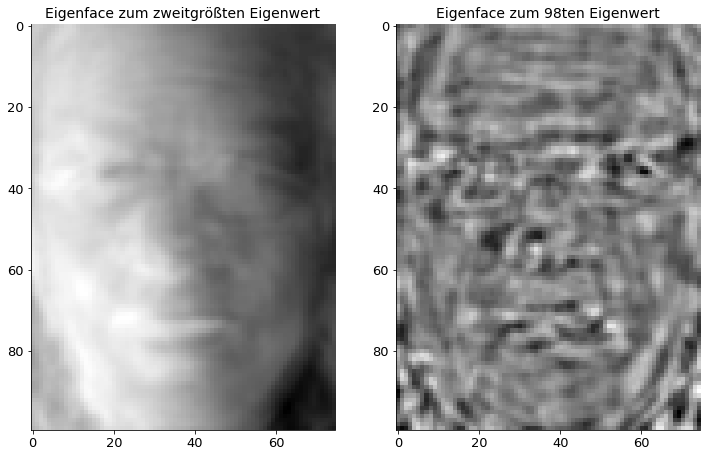

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(eigenfaces[1], cmap='gray')
ax1.set_title('Eigenface zum zweitgrößten Eigenwert')
ax2.imshow(eigenfaces[98], cmap='gray')
ax2.set_title('Eigenface zum 98ten Eigenwert')

## Feature Selection 

Eine anderer Ansatz zur Dimensionsreduzierung. Dabei werden die Daten nicht Transformiert sondern einfach Spalten entfernt die keine/wenig Aussagekraft besitzen. Die Aussagekraft bezieht dabei auf ein zu Lösendes Klassifizierungsproblem. Welche Spalten man verwerfen kann, ist also sehr Problemspezifisch. Im Allgemeinen folgen viele Feature Selection Ansätze der Heuristik:

> Good feature subsets contain features highly correlated with the classification, yet uncorrelated to each other.

> -- Mark Hall, Erfinder der CFS

### Univariate Feature Selection

Betrachtet jedes Attribut für sich alleinstehend. Häufig beinhaltet das auch eine Art der händischen Vorverarbeitung.

#### Korrelation mit der Zielgröße

Angenommen man wolle eine Größe $y$ aus einem 4D Datensatz schätzen. Ein Teil dieser Daten sind aber mit hohem Rauschen versehen oder haben mit der Zielgröße keinen Kausalen oder Statistischen Zusammenhang.

Ein einfacher Algorithmus sucht einfach nach den $k$ Attributen mit denhöchsten Korrelationen und entfernt alle anderen.

In dem Beispiel unten wird ein Datensatz erzeugt in welchem nur zwei der 4 vorhandenen Attribute mit der Zielgröße $y$ korrelieren. 

Korrelation zwischen Attribut 0 Ziel: 0.06461981340492828
Korrelation zwischen Attribut 1 Ziel: 0.2952903709849044
Korrelation zwischen Attribut 2 Ziel: 0.9565297002332779
Korrelation zwischen Attribut 3 Ziel: -0.00796785734910343


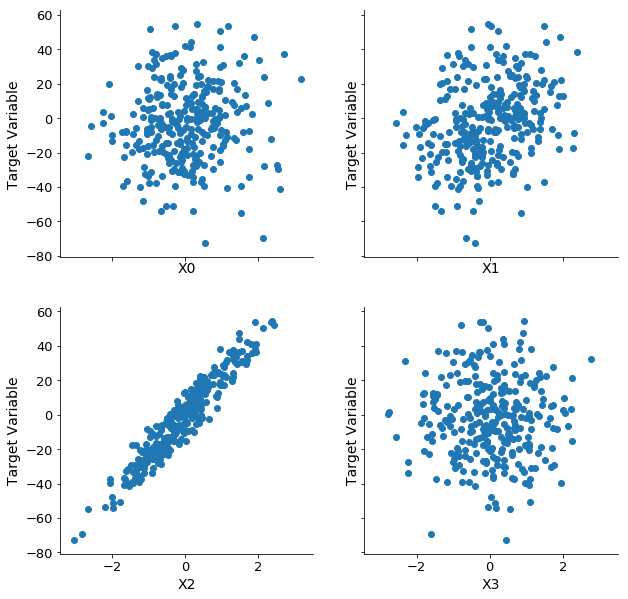

In [14]:
from sklearn.datasets import make_regression
from scipy.stats import pearsonr

X, y = make_regression(n_samples=300, n_features=4, n_informative=2, n_targets=1, random_state=0, noise=0.1)

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
for i in range(4):
    ax = axs.flatten()[i] 
    ax.scatter(X[:, i], y)
    ax.set_ylabel('Target Variable')
    ax.set_xlabel('X{}'.format(i))
    r, _ = pearsonr(X[:, i], y)
    print('Korrelation zwischen Attribut {} Ziel: {}'.format(i, r))

### Multivariate Feature Selection

Testet Kombinationen und ganze Untermengen aus Attributen nach verschiedenen Kriterien. Zum Beispiel Korrelation, Mutual Information, Kreuzentropie, Minimal Desciption Length oder einfach die Qualität der Klassifikation. 


#### Miteinander Korrelierte Attribute 

In dem Beispiel unten sieht man schnell, dass zwei Attribute miteinander korrelieren. Eines der beiden Attribute ist also überflüssig bzw. redundant. 

Um miteinander korrelierte Attribute zu finden kann man einfach alle Paare von Attributen miteinander verlgeichen. Der verlgeich von allen Paaren miteinander führt zur quadratischen Laufzeit dieser Methode.

Korrelation zwischen Attribut 0 und 1 : -0.21370115647312157
Korrelation zwischen Attribut 0 und 2 : 0.9505434622862089
Korrelation zwischen Attribut 1 und 2 : 0.1002843869707701


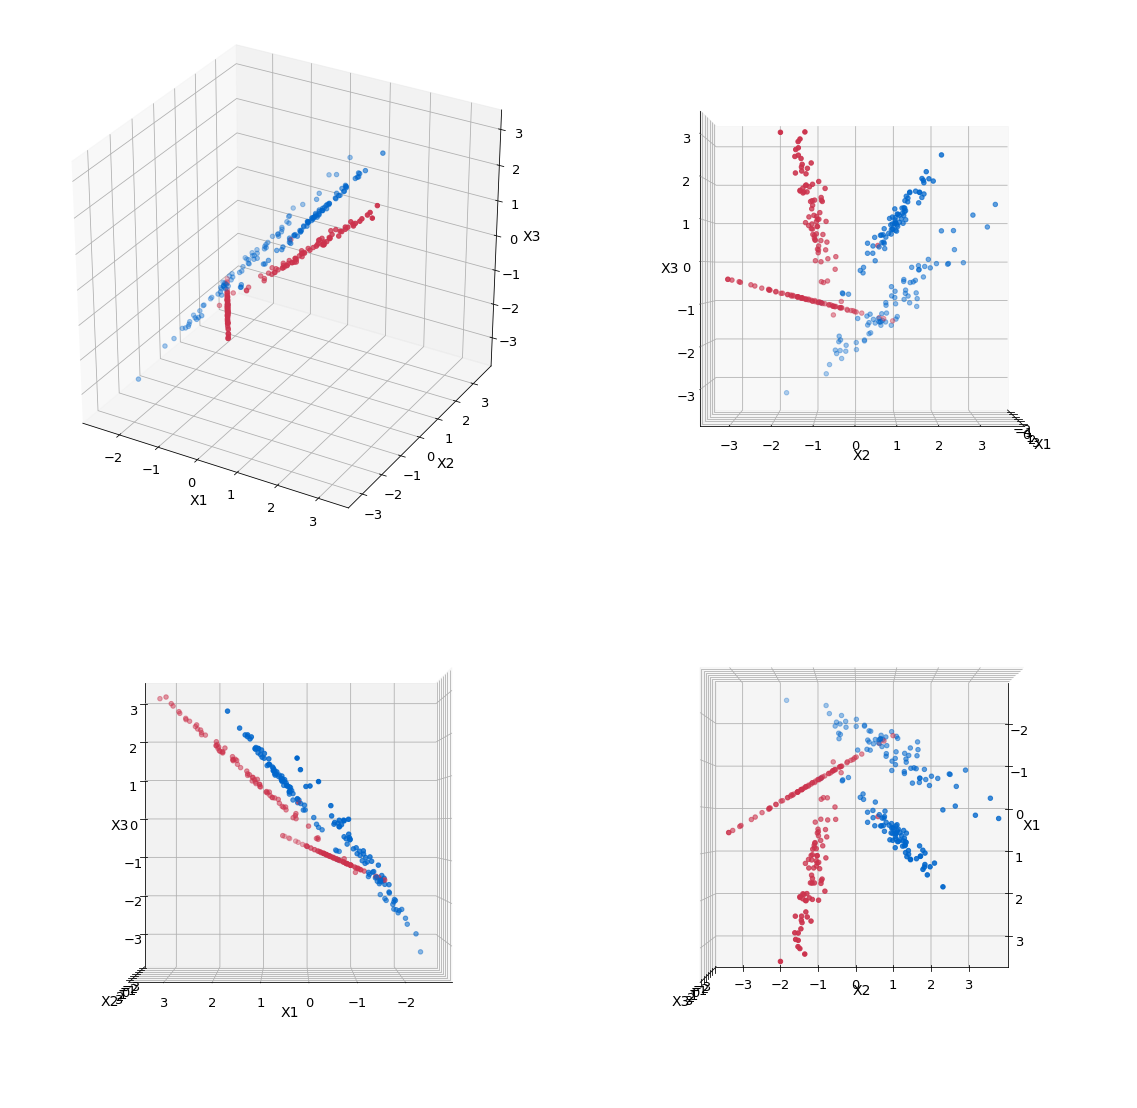

In [15]:
from sklearn.datasets import make_classification
from scipy.stats import pearsonr
from itertools import combinations

X, y = make_classification(n_samples=300, n_features=3, n_informative=2, n_redundant=1, n_repeated=0, n_classes=2, n_clusters_per_class=2, random_state=0)
plot_3d_views(X, y)

for i, j in combinations([0, 1, 2], 2):
    r, p = pearsonr(X[:, i], X[:, j])
    print('Korrelation zwischen Attribut {} und {} : {}'.format(i, j, r))

Es ist im allgemeinen nicht möglich alle Kombinationen von Attributen zu testen. Die Anzahl der möglichen Kombinationen ist exponentiell. Bei $n$ Attributen müssen nach Binomischen Lehrsatz Kombinationen getestet werden:

$$
N = \sum_{k = 1}^{n} \begin{pmatrix}
    n\\
    k\\
    \end{pmatrix} = 2^n -1
$$

Es gibt Selektionsstrategien und Heuristiken um weniger Kombinitionen  zu testen.  Die beiden einfachsten sind Forward/Backward Selection

###### Forward Selection:

Das Verfahren arbeitet Iterativ und testet untermengen nach einem festzulegendem Kriterium.
Starte mit dem einzelnen besten Attribut $f_0$ und füge so lange Attribute hinzu bis ein Abbruchkriterium erreicht ist. 

###### Backward Selection:

Wie Forward Selection aber es wird von der vollen Menge an Attributen gestartet un iterativ Einträge entfernt.

#### Max-Relevance, Min-Redundancy (mRMR)

Original veröffentlichung von Peng et al. (2005): [ieeexplore.ieee.org/document/1453511/](ieeexplore.ieee.org/document/1453511/)

Wähle die Untermenge an Attributen $S_k = \{f_1, f_2, \ldots, f_k\}$ die Insgesamt die höchste Relevanz bezüglich der Zielvariable $y$ hat und gleichzeitig die Korrelation zwischen den Attributen in $S_k$ möglichst klein ist.

Die Relevanz wird zum häufig durch ein Korrelationsmaß oder die sogenannte Mutual Information bestimmt.
Mehr zum Thema Mutual Information folgt noch. 

Für das gesuchte $S_k$ soll gelten $\max _{S_{k}}(D - R)$ wobei

\begin{align}
D(S, y) =& {\frac {1}{|S|}}\sum _{f_{i}\in S}I(f_{i}, y) \\
R(S)   =& {\frac {1}{|S|^{2}}}\sum _{f_{i},f_{j}\in S}I(f_{i}, f_{j}) 
\end{align}

Die Untermengen werden gebildet wie bei Forward Selection. Das nächste Attribut wird ausgewählt nach 

$$
\mathrm {mRMR} =\max _{S}\left[{\frac {1}{|S|}}\sum _{f_{i}\in S}I(f_{i}, y)-{\frac {1}{|S|^{2}}}\sum _{f_{i},f_{j}\in S}I(f_{i}, f_{j})\right].
$$

Der mRMR Algorithmus gehört zu einer Klasse von Algorithmen die versuchen Relevanz und Redundanz zu minimieren. Er hat einige interessante Eigenschaften aus informationstheoretischer Sicht und ist vor allem.

Feature Selection dieser Art ist vor allem dann Wichtig wenn die Anzahl der Attribute größer ist als die Anzahl der Beispiele im Datensatz.



### Feature Selection (Teil 2)

Zur Evaluierung, ob eine Feature Selection tatsächlich *gut* funktioniert,  muss letztendlich das zu lösende Klassifikationsproblem getestet werden. Ist die Klassifikation gut nachdem eine Untermenge der Attribute ausgewählt wurde, so war die Feature Selection erfolgreich. 


TODO. Kommt später.